In [10]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
% matplotlib inline

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate

from tqdm import tqdm_notebook
import datetime

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [3]:
train_df = pd.read_csv("data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [np.array(load_img("data/train/images/{}.png".format(idx), grayscale=True)) / 255 
                      for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

In [6]:
train_df["masks"] = [np.array(load_img("data/train/masks/{}.png".format(idx), grayscale=True)) / 255 
                     for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

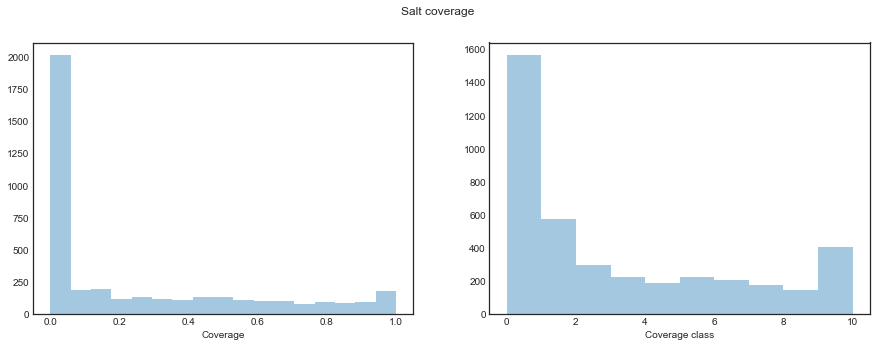

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

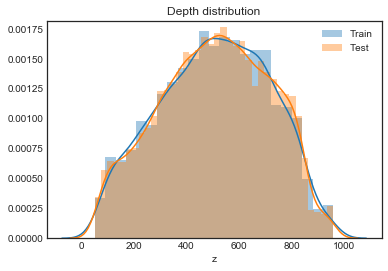

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

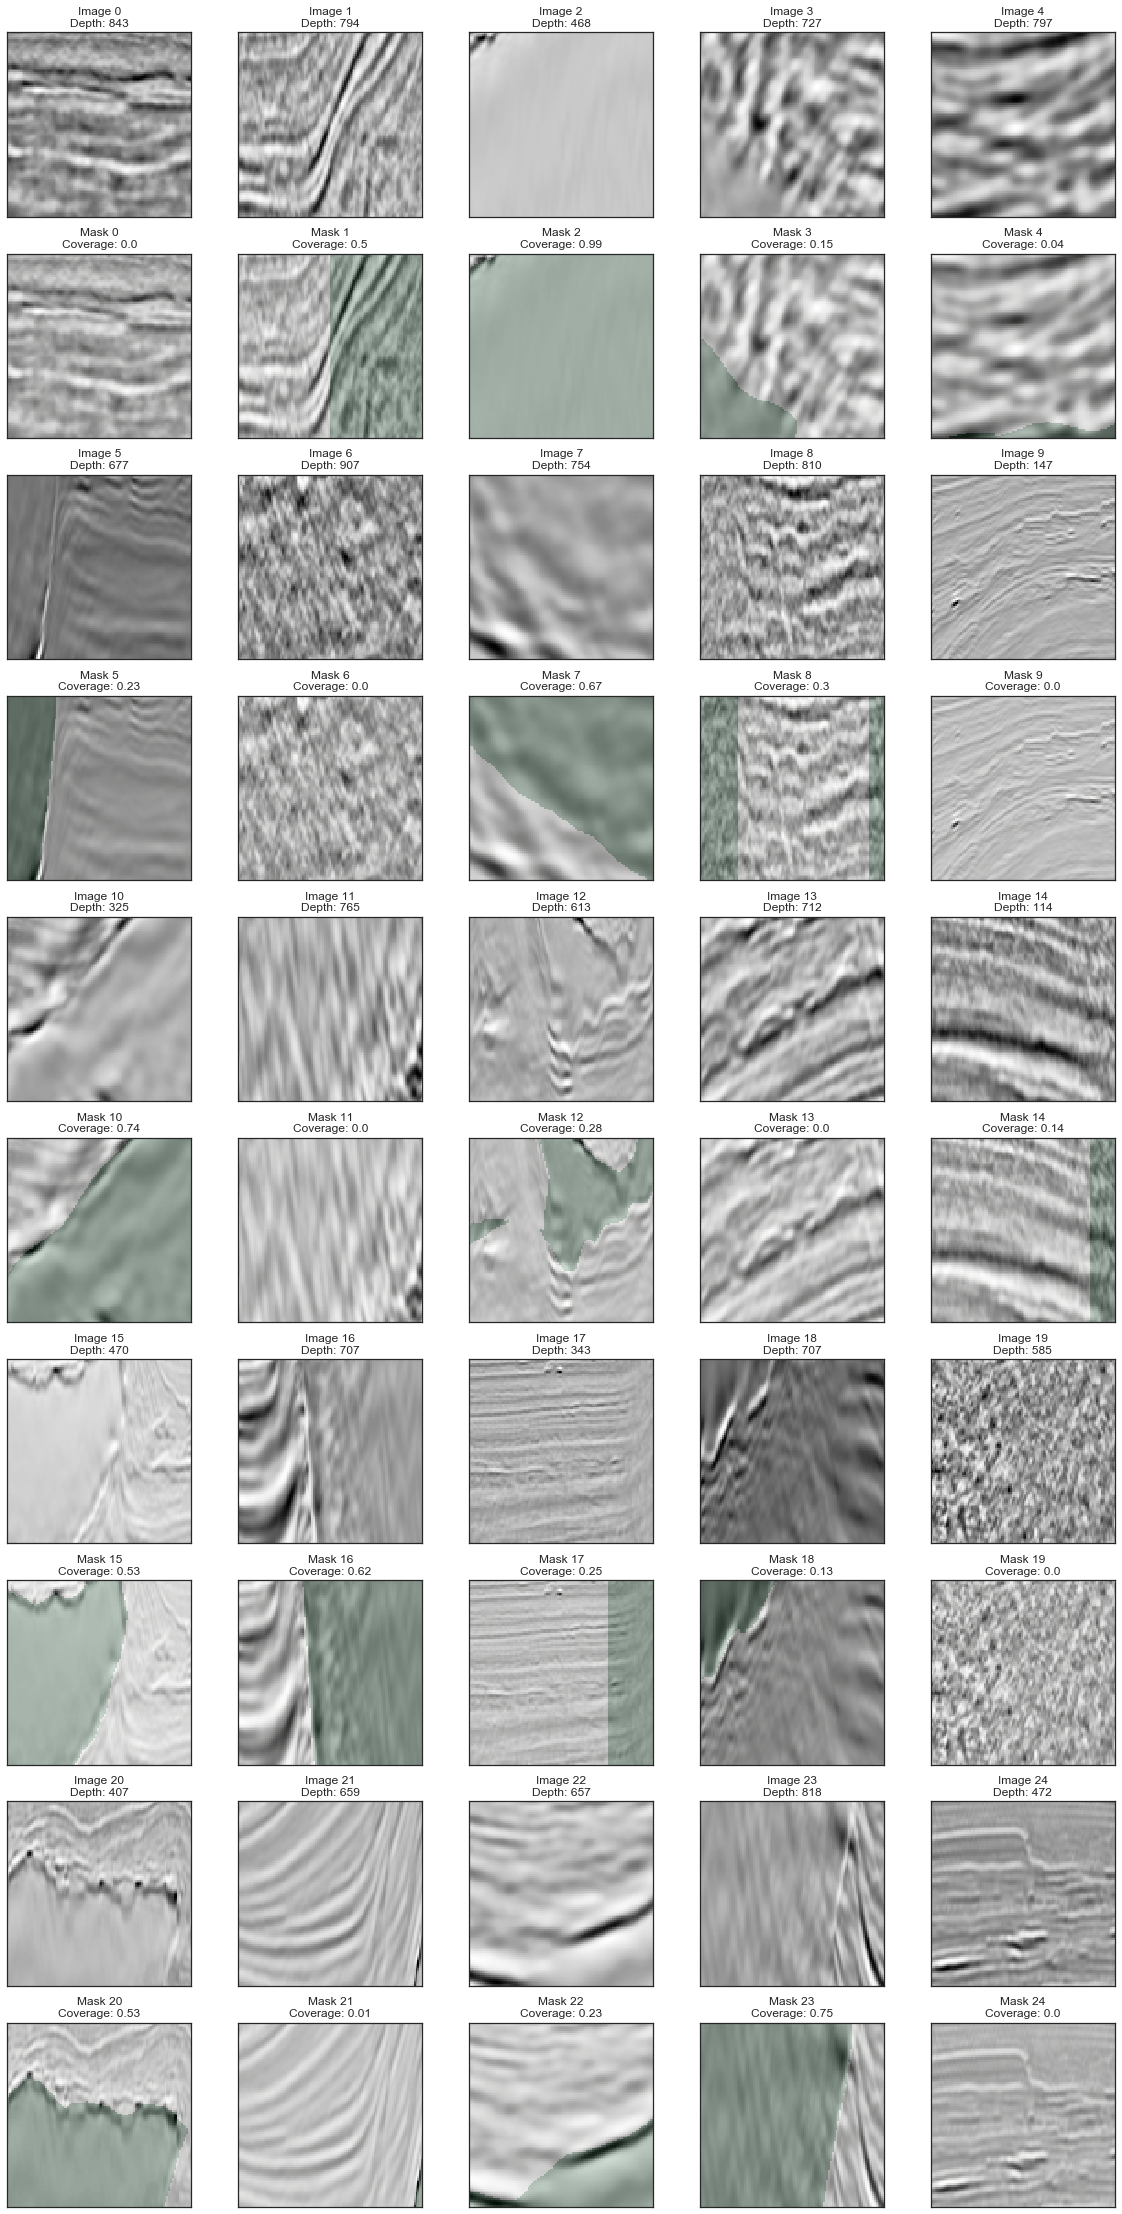

In [13]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

In [14]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [15]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [16]:
#model = Model(input_layer, output_layer)
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)

In [17]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [19]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

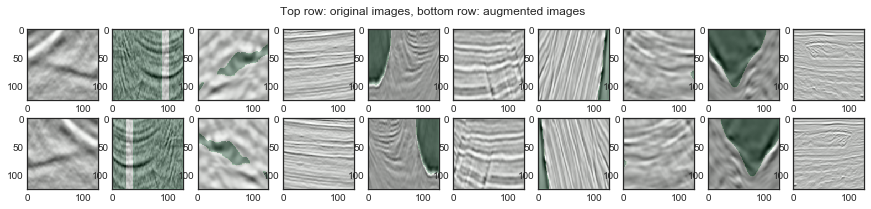

In [20]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [21]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("tgs-unet.h5", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 36:01 - loss: 0.8405 - acc: 0.52 - ETA: 18:09 - loss: 0.8176 - acc: 0.52 - ETA: 12:11 - loss: 0.7901 - acc: 0.54 - ETA: 9:12 - loss: 0.7734 - acc: 0.5514 - ETA: 7:25 - loss: 0.7680 - acc: 0.557 - ETA: 6:13 - loss: 0.7523 - acc: 0.566 - ETA: 5:22 - loss: 0.7356 - acc: 0.578 - ETA: 4:44 - loss: 0.7177 - acc: 0.594 - ETA: 4:14 - loss: 0.7037 - acc: 0.604 - ETA: 3:50 - loss: 0.6991 - acc: 0.608 - ETA: 3:30 - loss: 0.6941 - acc: 0.612 - ETA: 3:14 - loss: 0.6865 - acc: 0.617 - ETA: 3:00 - loss: 0.6840 - acc: 0.623 - ETA: 2:48 - loss: 0.6810 - acc: 0.625 - ETA: 2:37 - loss: 0.6742 - acc: 0.631 - ETA: 2:28 - loss: 0.6649 - acc: 0.639 - ETA: 2:20 - loss: 0.6579 - acc: 0.646 - ETA: 2:13 - loss: 0.6558 - acc: 0.649 - ETA: 2:07 - loss: 0.6493 - acc: 0.655 - ETA: 2:01 - loss: 0.6449 - acc: 0.660 - ETA: 1:56 - loss: 0.6383 - acc: 0.666 - ETA: 1:51 - loss: 0.6328 - acc: 0.672 - ETA: 1:47 - los

6400/6400 [==============================] - ETA: 26s - loss: 0.1536 - acc: 0.93 - ETA: 26s - loss: 0.1913 - acc: 0.92 - ETA: 26s - loss: 0.2279 - acc: 0.90 - ETA: 26s - loss: 0.2565 - acc: 0.89 - ETA: 26s - loss: 0.2759 - acc: 0.88 - ETA: 26s - loss: 0.2759 - acc: 0.88 - ETA: 26s - loss: 0.2770 - acc: 0.88 - ETA: 26s - loss: 0.2682 - acc: 0.89 - ETA: 26s - loss: 0.2638 - acc: 0.89 - ETA: 26s - loss: 0.2647 - acc: 0.89 - ETA: 25s - loss: 0.2613 - acc: 0.89 - ETA: 25s - loss: 0.2530 - acc: 0.89 - ETA: 25s - loss: 0.2552 - acc: 0.89 - ETA: 25s - loss: 0.2518 - acc: 0.89 - ETA: 25s - loss: 0.2450 - acc: 0.90 - ETA: 25s - loss: 0.2498 - acc: 0.89 - ETA: 25s - loss: 0.2459 - acc: 0.89 - ETA: 24s - loss: 0.2472 - acc: 0.89 - ETA: 24s - loss: 0.2471 - acc: 0.89 - ETA: 24s - loss: 0.2416 - acc: 0.89 - ETA: 24s - loss: 0.2365 - acc: 0.90 - ETA: 24s - loss: 0.2328 - acc: 0.90 - ETA: 24s - loss: 0.2340 - acc: 0.90 - ETA: 24s - loss: 0.2300 - acc: 0.90 - ETA: 23s - loss: 0.2304 - acc: 0.90 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.2295 - acc: 0.90 - ETA: 27s - loss: 0.2853 - acc: 0.87 - ETA: 27s - loss: 0.2543 - acc: 0.88 - ETA: 27s - loss: 0.2312 - acc: 0.89 - ETA: 27s - loss: 0.2246 - acc: 0.90 - ETA: 27s - loss: 0.2083 - acc: 0.91 - ETA: 26s - loss: 0.2324 - acc: 0.90 - ETA: 26s - loss: 0.2272 - acc: 0.90 - ETA: 26s - loss: 0.2202 - acc: 0.90 - ETA: 26s - loss: 0.2150 - acc: 0.91 - ETA: 26s - loss: 0.2123 - acc: 0.91 - ETA: 26s - loss: 0.2064 - acc: 0.91 - ETA: 26s - loss: 0.2202 - acc: 0.90 - ETA: 25s - loss: 0.2148 - acc: 0.91 - ETA: 25s - loss: 0.2145 - acc: 0.91 - ETA: 25s - loss: 0.2124 - acc: 0.91 - ETA: 25s - loss: 0.2094 - acc: 0.91 - ETA: 25s - loss: 0.2052 - acc: 0.91 - ETA: 25s - loss: 0.2019 - acc: 0.91 - ETA: 24s - loss: 0.2091 - acc: 0.91 - ETA: 24s - loss: 0.2101 - acc: 0.91 - ETA: 24s - loss: 0.2143 - acc: 0.91 - ETA: 24s - loss: 0.2105 - acc: 0.91 - ETA: 24s - loss: 0.2092 - acc: 0.91 - ETA: 24s - loss: 0.2068 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 26s - loss: 0.1534 - acc: 0.93 - ETA: 27s - loss: 0.1624 - acc: 0.92 - ETA: 27s - loss: 0.1837 - acc: 0.91 - ETA: 27s - loss: 0.1666 - acc: 0.92 - ETA: 26s - loss: 0.1886 - acc: 0.91 - ETA: 26s - loss: 0.1970 - acc: 0.91 - ETA: 26s - loss: 0.2052 - acc: 0.91 - ETA: 26s - loss: 0.1983 - acc: 0.91 - ETA: 26s - loss: 0.2023 - acc: 0.91 - ETA: 25s - loss: 0.1954 - acc: 0.91 - ETA: 25s - loss: 0.1998 - acc: 0.91 - ETA: 25s - loss: 0.1908 - acc: 0.92 - ETA: 25s - loss: 0.1832 - acc: 0.92 - ETA: 25s - loss: 0.1845 - acc: 0.92 - ETA: 25s - loss: 0.1822 - acc: 0.92 - ETA: 25s - loss: 0.1818 - acc: 0.92 - ETA: 25s - loss: 0.1826 - acc: 0.92 - ETA: 25s - loss: 0.1779 - acc: 0.92 - ETA: 24s - loss: 0.1755 - acc: 0.92 - ETA: 24s - loss: 0.1762 - acc: 0.92 - ETA: 24s - loss: 0.1725 - acc: 0.92 - ETA: 24s - loss: 0.1708 - acc: 0.92 - ETA: 24s - loss: 0.1708 - acc: 0.92 - ETA: 24s - loss: 0.1764 - acc: 0.92 - ETA: 24s - loss: 0.1762 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.1429 - acc: 0.93 - ETA: 27s - loss: 0.1321 - acc: 0.93 - ETA: 27s - loss: 0.1243 - acc: 0.94 - ETA: 27s - loss: 0.1288 - acc: 0.94 - ETA: 27s - loss: 0.1358 - acc: 0.94 - ETA: 27s - loss: 0.1338 - acc: 0.94 - ETA: 26s - loss: 0.1396 - acc: 0.94 - ETA: 26s - loss: 0.1351 - acc: 0.94 - ETA: 26s - loss: 0.1341 - acc: 0.94 - ETA: 26s - loss: 0.1418 - acc: 0.93 - ETA: 26s - loss: 0.1395 - acc: 0.94 - ETA: 26s - loss: 0.1370 - acc: 0.94 - ETA: 26s - loss: 0.1439 - acc: 0.93 - ETA: 25s - loss: 0.1397 - acc: 0.93 - ETA: 25s - loss: 0.1375 - acc: 0.93 - ETA: 25s - loss: 0.1387 - acc: 0.93 - ETA: 25s - loss: 0.1377 - acc: 0.93 - ETA: 25s - loss: 0.1407 - acc: 0.93 - ETA: 25s - loss: 0.1401 - acc: 0.93 - ETA: 25s - loss: 0.1420 - acc: 0.93 - ETA: 25s - loss: 0.1447 - acc: 0.93 - ETA: 24s - loss: 0.1481 - acc: 0.93 - ETA: 24s - loss: 0.1479 - acc: 0.93 - ETA: 24s - loss: 0.1474 - acc: 0.93 - ETA: 24s - loss: 0.1500 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 26s - loss: 0.1600 - acc: 0.92 - ETA: 26s - loss: 0.1322 - acc: 0.94 - ETA: 26s - loss: 0.1787 - acc: 0.92 - ETA: 26s - loss: 0.1560 - acc: 0.92 - ETA: 26s - loss: 0.1451 - acc: 0.93 - ETA: 26s - loss: 0.1376 - acc: 0.94 - ETA: 26s - loss: 0.1365 - acc: 0.94 - ETA: 26s - loss: 0.1440 - acc: 0.93 - ETA: 26s - loss: 0.1411 - acc: 0.94 - ETA: 26s - loss: 0.1371 - acc: 0.94 - ETA: 26s - loss: 0.1430 - acc: 0.93 - ETA: 26s - loss: 0.1409 - acc: 0.93 - ETA: 25s - loss: 0.1426 - acc: 0.93 - ETA: 25s - loss: 0.1444 - acc: 0.93 - ETA: 25s - loss: 0.1416 - acc: 0.93 - ETA: 25s - loss: 0.1376 - acc: 0.94 - ETA: 25s - loss: 0.1355 - acc: 0.94 - ETA: 25s - loss: 0.1348 - acc: 0.94 - ETA: 25s - loss: 0.1359 - acc: 0.94 - ETA: 24s - loss: 0.1356 - acc: 0.94 - ETA: 24s - loss: 0.1366 - acc: 0.94 - ETA: 24s - loss: 0.1355 - acc: 0.94 - ETA: 24s - loss: 0.1346 - acc: 0.94 - ETA: 24s - loss: 0.1355 - acc: 0.94 - ETA: 24s - loss: 0.1356 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.0854 - acc: 0.96 - ETA: 27s - loss: 0.0976 - acc: 0.95 - ETA: 27s - loss: 0.1133 - acc: 0.94 - ETA: 27s - loss: 0.1237 - acc: 0.94 - ETA: 27s - loss: 0.1163 - acc: 0.94 - ETA: 27s - loss: 0.1316 - acc: 0.94 - ETA: 27s - loss: 0.1408 - acc: 0.93 - ETA: 27s - loss: 0.1344 - acc: 0.94 - ETA: 26s - loss: 0.1316 - acc: 0.94 - ETA: 26s - loss: 0.1297 - acc: 0.94 - ETA: 26s - loss: 0.1342 - acc: 0.94 - ETA: 26s - loss: 0.1394 - acc: 0.94 - ETA: 26s - loss: 0.1437 - acc: 0.93 - ETA: 26s - loss: 0.1413 - acc: 0.93 - ETA: 26s - loss: 0.1411 - acc: 0.93 - ETA: 25s - loss: 0.1375 - acc: 0.93 - ETA: 25s - loss: 0.1367 - acc: 0.93 - ETA: 25s - loss: 0.1368 - acc: 0.93 - ETA: 25s - loss: 0.1365 - acc: 0.93 - ETA: 25s - loss: 0.1386 - acc: 0.93 - ETA: 25s - loss: 0.1353 - acc: 0.93 - ETA: 25s - loss: 0.1321 - acc: 0.94 - ETA: 24s - loss: 0.1300 - acc: 0.94 - ETA: 24s - loss: 0.1285 - acc: 0.94 - ETA: 24s - loss: 0.1266 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.0622 - acc: 0.97 - ETA: 27s - loss: 0.0799 - acc: 0.96 - ETA: 27s - loss: 0.0966 - acc: 0.95 - ETA: 27s - loss: 0.1232 - acc: 0.94 - ETA: 27s - loss: 0.1264 - acc: 0.94 - ETA: 27s - loss: 0.1181 - acc: 0.94 - ETA: 27s - loss: 0.1236 - acc: 0.94 - ETA: 27s - loss: 0.1244 - acc: 0.93 - ETA: 26s - loss: 0.1209 - acc: 0.94 - ETA: 26s - loss: 0.1261 - acc: 0.93 - ETA: 26s - loss: 0.1242 - acc: 0.93 - ETA: 26s - loss: 0.1218 - acc: 0.94 - ETA: 26s - loss: 0.1195 - acc: 0.94 - ETA: 26s - loss: 0.1156 - acc: 0.94 - ETA: 26s - loss: 0.1137 - acc: 0.94 - ETA: 25s - loss: 0.1114 - acc: 0.94 - ETA: 25s - loss: 0.1095 - acc: 0.94 - ETA: 25s - loss: 0.1073 - acc: 0.94 - ETA: 25s - loss: 0.1076 - acc: 0.94 - ETA: 25s - loss: 0.1063 - acc: 0.94 - ETA: 25s - loss: 0.1095 - acc: 0.94 - ETA: 25s - loss: 0.1084 - acc: 0.94 - ETA: 24s - loss: 0.1161 - acc: 0.94 - ETA: 24s - loss: 0.1139 - acc: 0.94 - ETA: 24s - loss: 0.1155 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.0851 - acc: 0.96 - ETA: 29s - loss: 0.0728 - acc: 0.96 - ETA: 28s - loss: 0.0860 - acc: 0.96 - ETA: 28s - loss: 0.0896 - acc: 0.95 - ETA: 27s - loss: 0.0793 - acc: 0.96 - ETA: 27s - loss: 0.0737 - acc: 0.96 - ETA: 27s - loss: 0.0763 - acc: 0.96 - ETA: 27s - loss: 0.0788 - acc: 0.95 - ETA: 26s - loss: 0.0779 - acc: 0.96 - ETA: 26s - loss: 0.0787 - acc: 0.96 - ETA: 26s - loss: 0.0797 - acc: 0.96 - ETA: 26s - loss: 0.0772 - acc: 0.96 - ETA: 26s - loss: 0.0809 - acc: 0.96 - ETA: 26s - loss: 0.0807 - acc: 0.96 - ETA: 25s - loss: 0.0826 - acc: 0.96 - ETA: 25s - loss: 0.0802 - acc: 0.96 - ETA: 25s - loss: 0.0799 - acc: 0.96 - ETA: 25s - loss: 0.0785 - acc: 0.96 - ETA: 25s - loss: 0.0774 - acc: 0.96 - ETA: 25s - loss: 0.0764 - acc: 0.96 - ETA: 25s - loss: 0.0781 - acc: 0.96 - ETA: 24s - loss: 0.0781 - acc: 0.96 - ETA: 24s - loss: 0.0799 - acc: 0.96 - ETA: 24s - loss: 0.0796 - acc: 0.96 - ETA: 24s - loss: 0.0844 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.0624 - acc: 0.97 - ETA: 27s - loss: 0.0478 - acc: 0.97 - ETA: 27s - loss: 0.0574 - acc: 0.97 - ETA: 27s - loss: 0.0580 - acc: 0.97 - ETA: 27s - loss: 0.0674 - acc: 0.96 - ETA: 27s - loss: 0.0690 - acc: 0.96 - ETA: 26s - loss: 0.0732 - acc: 0.96 - ETA: 26s - loss: 0.0790 - acc: 0.96 - ETA: 26s - loss: 0.0824 - acc: 0.96 - ETA: 26s - loss: 0.0791 - acc: 0.96 - ETA: 26s - loss: 0.0759 - acc: 0.96 - ETA: 26s - loss: 0.0888 - acc: 0.95 - ETA: 26s - loss: 0.0901 - acc: 0.95 - ETA: 26s - loss: 0.0895 - acc: 0.95 - ETA: 26s - loss: 0.0881 - acc: 0.95 - ETA: 25s - loss: 0.0865 - acc: 0.95 - ETA: 25s - loss: 0.0857 - acc: 0.95 - ETA: 25s - loss: 0.0859 - acc: 0.95 - ETA: 25s - loss: 0.0842 - acc: 0.95 - ETA: 25s - loss: 0.0868 - acc: 0.95 - ETA: 25s - loss: 0.0877 - acc: 0.95 - ETA: 24s - loss: 0.0878 - acc: 0.95 - ETA: 24s - loss: 0.0862 - acc: 0.95 - ETA: 24s - loss: 0.0862 - acc: 0.95 - ETA: 24s - loss: 0.0871 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 27s - loss: 0.1056 - acc: 0.95 - ETA: 27s - loss: 0.0777 - acc: 0.96 - ETA: 27s - loss: 0.0902 - acc: 0.95 - ETA: 27s - loss: 0.0797 - acc: 0.96 - ETA: 27s - loss: 0.0823 - acc: 0.95 - ETA: 27s - loss: 0.0782 - acc: 0.96 - ETA: 27s - loss: 0.0775 - acc: 0.96 - ETA: 27s - loss: 0.0788 - acc: 0.95 - ETA: 26s - loss: 0.0758 - acc: 0.96 - ETA: 26s - loss: 0.0801 - acc: 0.95 - ETA: 26s - loss: 0.0794 - acc: 0.96 - ETA: 26s - loss: 0.0780 - acc: 0.96 - ETA: 26s - loss: 0.0780 - acc: 0.96 - ETA: 26s - loss: 0.0858 - acc: 0.95 - ETA: 26s - loss: 0.0854 - acc: 0.95 - ETA: 25s - loss: 0.0872 - acc: 0.95 - ETA: 25s - loss: 0.0953 - acc: 0.95 - ETA: 25s - loss: 0.0934 - acc: 0.95 - ETA: 25s - loss: 0.0921 - acc: 0.95 - ETA: 25s - loss: 0.0921 - acc: 0.95 - ETA: 25s - loss: 0.0907 - acc: 0.95 - ETA: 25s - loss: 0.0892 - acc: 0.95 - ETA: 24s - loss: 0.0891 - acc: 0.95 - ETA: 24s - loss: 0.0882 - acc: 0.95 - ETA: 24s - loss: 0.0872 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 26s - loss: 0.0513 - acc: 0.96 - ETA: 26s - loss: 0.0493 - acc: 0.97 - ETA: 26s - loss: 0.0614 - acc: 0.96 - ETA: 26s - loss: 0.0758 - acc: 0.96 - ETA: 26s - loss: 0.0735 - acc: 0.96 - ETA: 26s - loss: 0.0696 - acc: 0.96 - ETA: 26s - loss: 0.0969 - acc: 0.95 - ETA: 26s - loss: 0.0930 - acc: 0.95 - ETA: 25s - loss: 0.1156 - acc: 0.95 - ETA: 25s - loss: 0.1276 - acc: 0.94 - ETA: 25s - loss: 0.1254 - acc: 0.94 - ETA: 25s - loss: 0.1262 - acc: 0.94 - ETA: 25s - loss: 0.1221 - acc: 0.94 - ETA: 25s - loss: 0.1249 - acc: 0.94 - ETA: 25s - loss: 0.1328 - acc: 0.94 - ETA: 24s - loss: 0.1281 - acc: 0.94 - ETA: 24s - loss: 0.1256 - acc: 0.94 - ETA: 24s - loss: 0.1260 - acc: 0.94 - ETA: 24s - loss: 0.1247 - acc: 0.94 - ETA: 24s - loss: 0.1219 - acc: 0.94 - ETA: 24s - loss: 0.1194 - acc: 0.95 - ETA: 24s - loss: 0.1173 - acc: 0.95 - ETA: 24s - loss: 0.1143 - acc: 0.95 - ETA: 23s - loss: 0.1120 - acc: 0.95 - ETA: 23s - loss: 0.1102 - acc: 0.95 - ETA: 

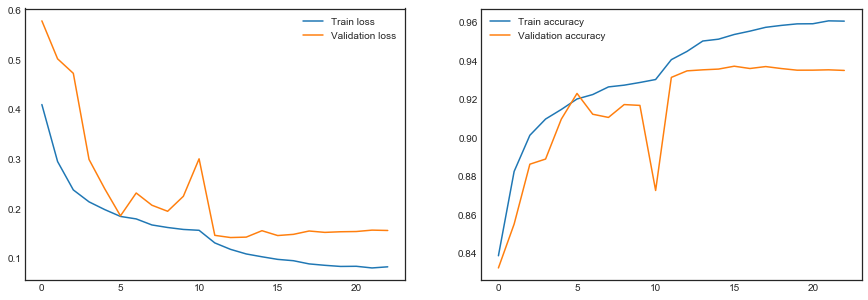

In [22]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [23]:
#model = load_model("tgs-unet.h5")

In [24]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

In [25]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [26]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) 
                 for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

In [27]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

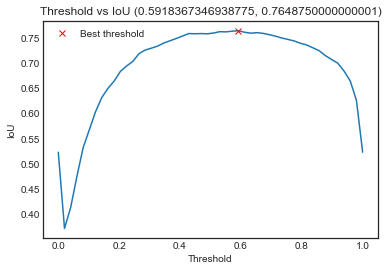

In [28]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

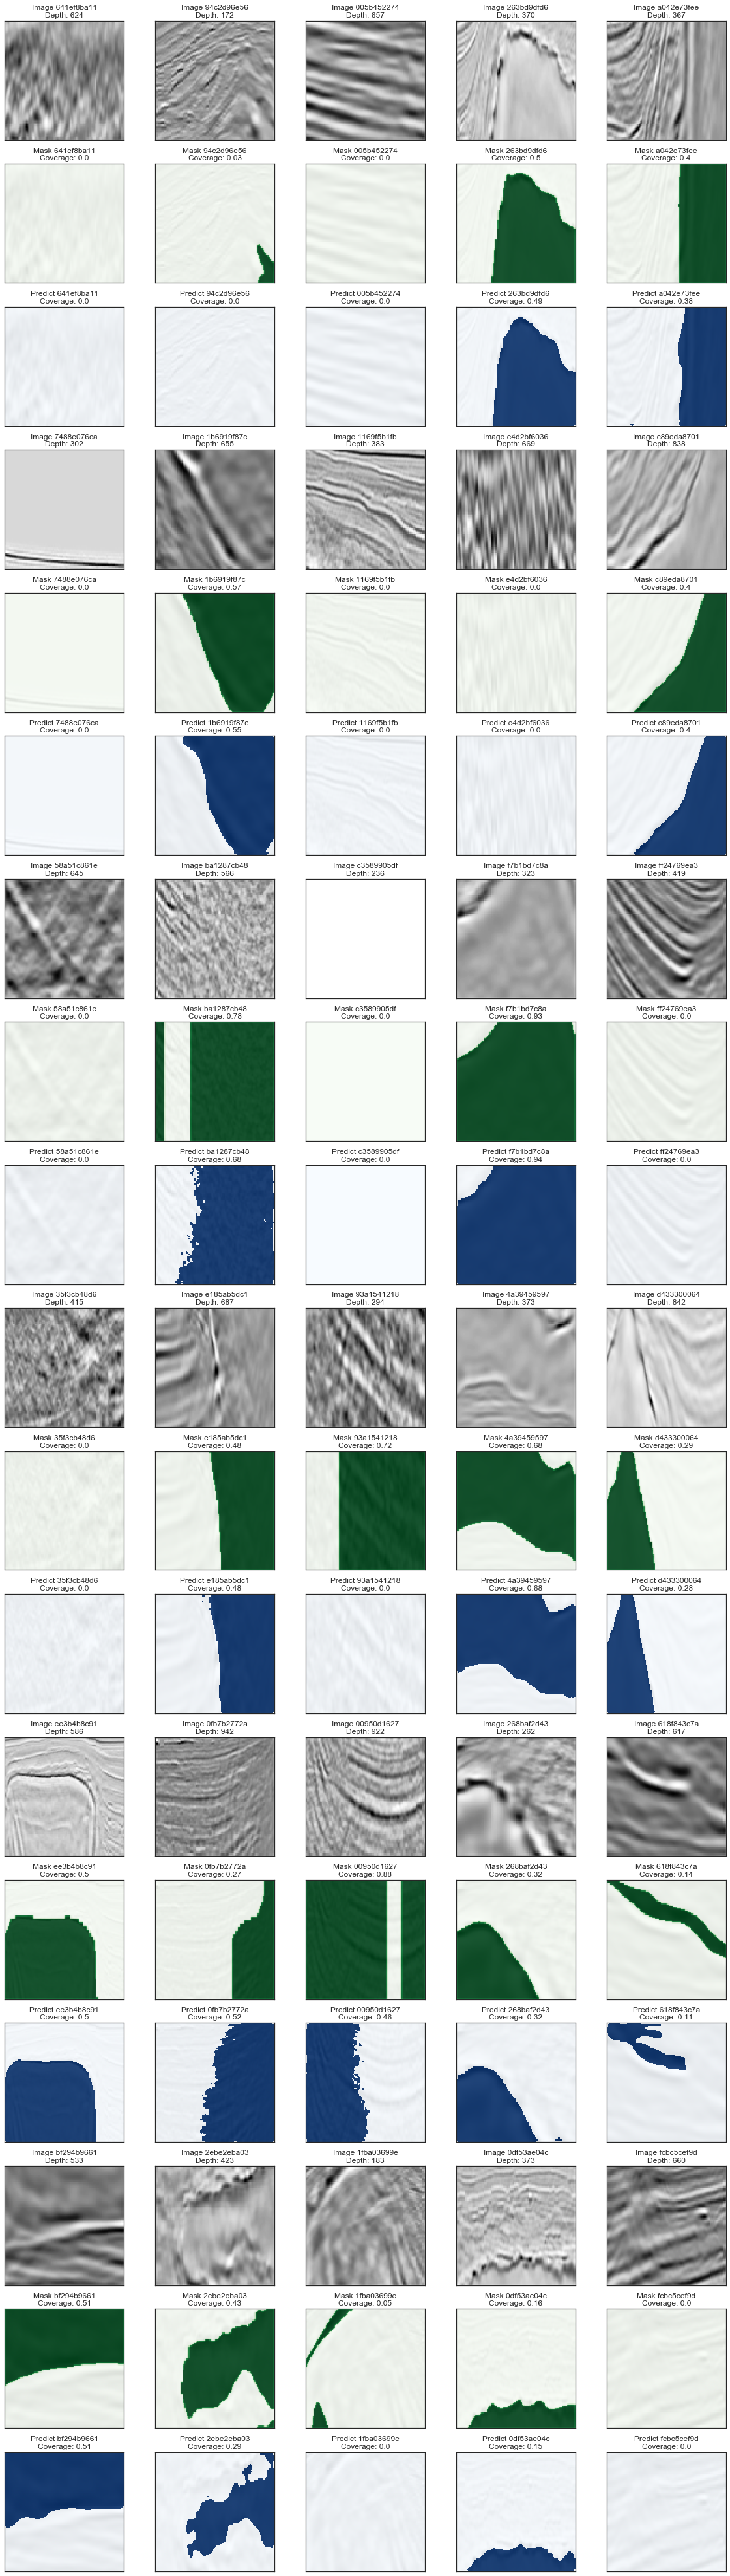

In [29]:
max_images = 30
grid_width = 5
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(idx, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(idx,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict {0}\nCoverage: {1}".format(idx,  round(coverage_pred, 2)))
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

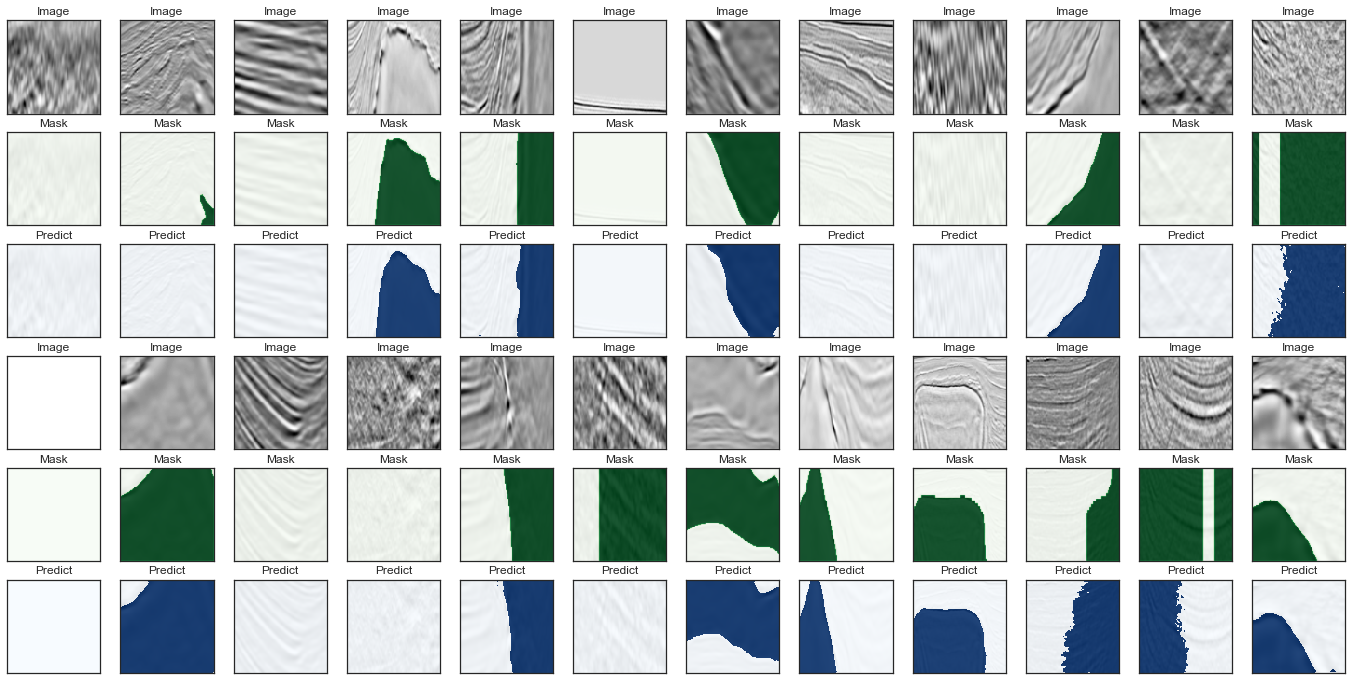

In [30]:
# plot small charts
max_images = 24
grid_width = 12
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask")
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

In [31]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [33]:
x_test = np.array([upsample(np.array(load_img("data/test/images/{}.png".format(idx), grayscale=True))) / 255
                   for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

A Jupyter Widget

In [34]:
preds_test = model.predict(x_test)

In [35]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best))
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

A Jupyter Widget

In [36]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv("sub-{}.csv".format(timestamp))

Submission output to: sub-20180817-0054.csv
